# Lab 4: Testing a Variational Quantum Classifier on a real backend


In [1]:
# Import all in one cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

In [2]:
### Save API Token, if needed

#%set_env QXToken=**
%set_env QC_GRADE_ONLY=true

env: QC_GRADE_ONLY=true


In [3]:
from qc_grader.challenges.iqc_2024 import (
    grade_lab4_ex1,
    grade_lab4_ex2,
    grade_lab4_ex3,
    grade_lab4_ex4,
    grade_lab4_ex5,
    grade_lab4_ex6,
    grade_lab4_ex7
)

## Part 1: Design a VQC on an ideal backend

Variational quantum classifiers (VQCs) are a type of variational quantum algorithm that can solve certain types of classification problems. In particular, VQCs feature a hybrid architecture. This architecture is based on an ansatz in the form of a parametrized quantum circuit applied onto an initial state. The output is measured in the form of a cost function, which is classically optimized over the circuit's parameters until we converge to a minimum.

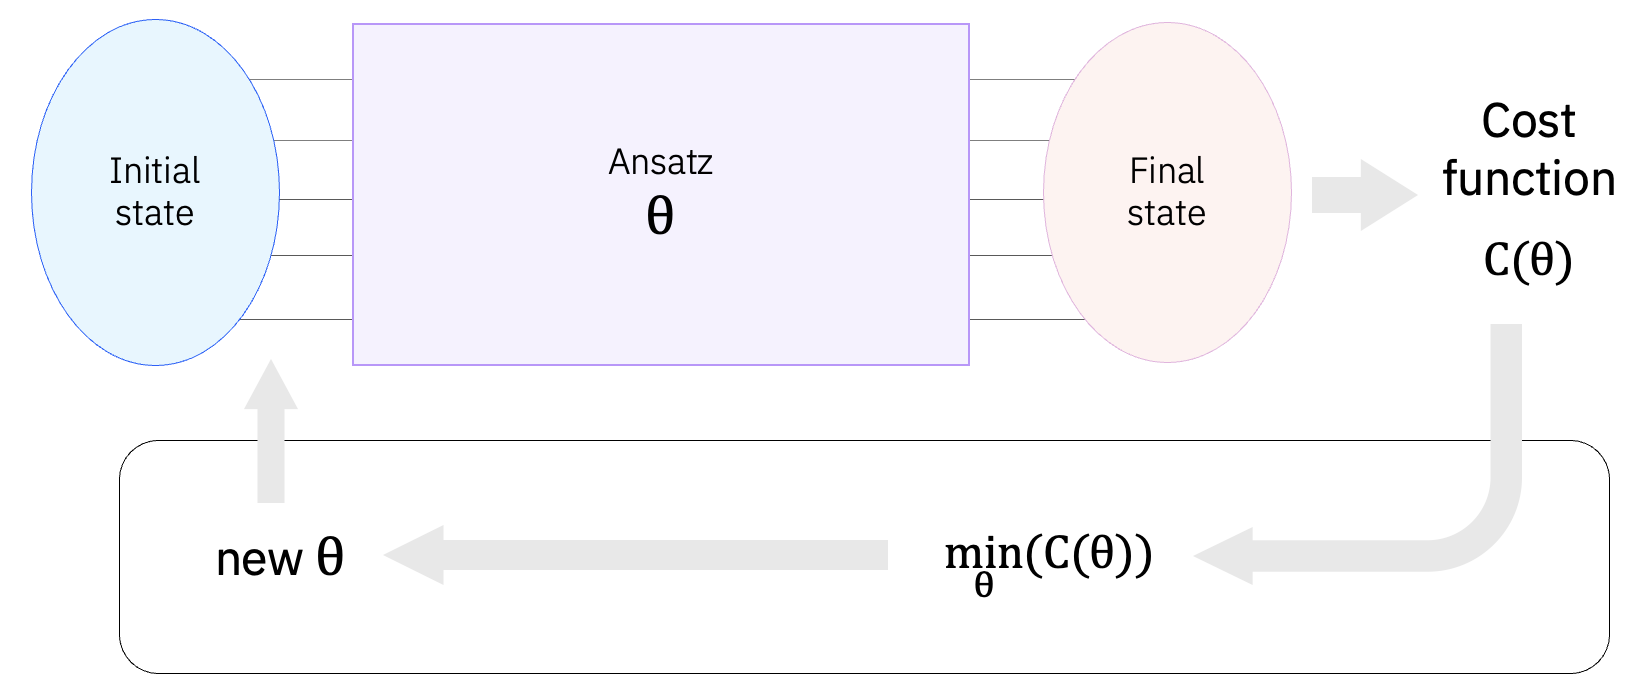

In this Lab, you are given a list of 10 birds:

 > Falcon, Hummingbird, Eagle, Osprey, Heron, Peacock, Parrot, Swan, Toucan, Cardinal.

The first five birds in the list are IBM Quantum birds, since processor types were named after them - check them out [here](https://docs.quantum.ibm.com/run/processor-types). The rest of them are non-IBM Quantum birds.

The dataset is given to you in the form of a dictionary, *bird_dataset.csv*. Each bird corresponds to an entry, and it is associated with a 5-qubit quantum state given in a _statevector_ form. Therefore, for each bird you will find $2^5 = 32$ coefficients.

### Step 1: Map classical inputs to a quantum problem

In this step of Qiskit Patterns, we are interested in translating a problem into a quantum circuit and a set of measurements that can reasonably run on quantum hardware. Note that this is in general a hard problem, so here's a list of things to take into account:

- We want to choose problems that are classically hard. Distinguishing between entangled and non-entangled states is a classically hard problem, even though we are choosing a small-scale problem for our learning purposes.
- We need to translate the outcomes into an expectation value or a _cost function_. A _cost function_ is a problem-specific function that defines the problem's outcome as something to be minimized or maximized, and it is typically used for variational quantum algorithms with various applications in chemistry, machine learning, finance, optimization, etc.
- When possible, we should keep in mind the limitations and advantages of the hardware that we are going to use. In particular, the backend's connectivity is important: we want to map the problem to a circuit that is as close as possible to the IBM Quantum processors’ heavy-hex topology to avoid having to implement a lot of SWAP gates.

For now, let's first retrieve the classical data, which in this case are the _statevector_ coefficients for each of the birds.

In [4]:
# Define num_qubits, the number of qubits, for the rest of the Lab
num_qubits = 5

# Load the dictionary 
birds_dataset = pd.read_csv('birds_dataset.csv') 

# Check if the dataset is loaded correctly - coefficients should be complex numbers
for i in range(2**num_qubits):
    key = 'c%.0f' %i
    birds_dataset[key] = birds_dataset[key].astype(np.complex128)

# Print the dataset
birds_dataset.head()

,names,c0,c1,c2,c3,c4,c5,c6,c7,c8,...,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31
0,Falcon,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j
1,Hummingbird,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j
2,Eagle,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,Osprey,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
4,Heron,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j


<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 

Retrieve the coefficients of each of the quantum states from the dictionary. Save them in a list of lists containing complex numbers: ```[[], [], [], ...]```. Create a corresponding list of labels with label 1 for IBM Quantum birds and label 0 for non-IBM Quantum birds: ```[int, int, ...]```.
    
</div>

In [5]:
# Retrieve the coefficients
coefficients = []
labels = []

for index, row in birds_dataset.iterrows():
    # Extract coefficients for this row and append to the coefficients
    coeff_list = []
    for i in range(2**num_qubits):
        key = 'c%.0f' % i
        coeff_list.append(row[key])
    coefficients.append(coeff_list)
    
# Check the results
print("Coefficients:", coefficients)

Coefficients: [[(0.7071067811865476+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.7071067811865476+0j)], [0j, (0.7071067811865476+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.7071067811865476+0j), 0j], [0j, 0j, (0.7071067811865476+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.7071067811865476+0j), 0j, 0j], [0j, 0j, 0j, (0.7071067811865476+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.7071067811865476+0j), 0j, 0j, 0j], [0j, 0j, 0j, 0j, (0.7071067811865476+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.7071067811865476+0j), 0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j, 0j, (1+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 

In [6]:
list_coefficients =   coefficients     # Add your code here
list_labels =   [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]           # Add your code here

In [7]:
# Submit your answer using following code 
grade_lab4_ex1(list_coefficients, list_labels)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


Now that the data is ready, we want to map it onto the quantum circuit. In this case, we are going to use the **amplitude embedding** technique, which can be easily implemented in Qiskit via [initialization](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.Initialize). Since each of our $32$ coefficients corresponds to the amplitude of one of the basis states of a 5-qubit Hilbert space, the amplitude embedding is a straightforward mapping for this kind of dataset. As we will see later, `qc.initialize` is a general function that can map any quantum state. However, this function can lead to very deep circuits. Given that we don't yet have full information on the dataset, we will use this mapping approach for now.

For more general classification problems, we can consider other mappings. The choice of the mapping should depend on the structure of the dataset that we are given. In general, the data is mapped onto the parameters of a set of parametrized quantum gates. A typical example is the [ZZ Feature Map](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap).

Let's build the amplitude embedding circuit and take a look at it:

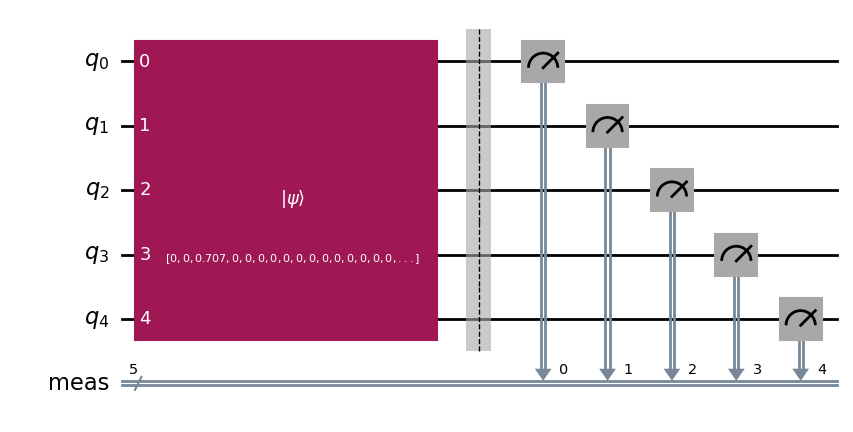

In [8]:
index_bird = 2      # You can check different birds by changing the index
amplitudes = list_coefficients[index_bird]

# Build the amplitude embedding 
qc = QuantumCircuit(5)
qc.initialize(amplitudes, range(num_qubits))
qc.measure_all()

# Draw the amplitude embedding circuit
qc.draw(output="mpl")

If we decompose the circuit before drawing it, we can better see its structure. As mentioned above, the ```qc.initialize()```function leads to a very deep circuit. In fact, the problem of state preparation, which aims at mapping an arbitrary quantum state onto a quantum circuit efficiently, is still an open research problem.

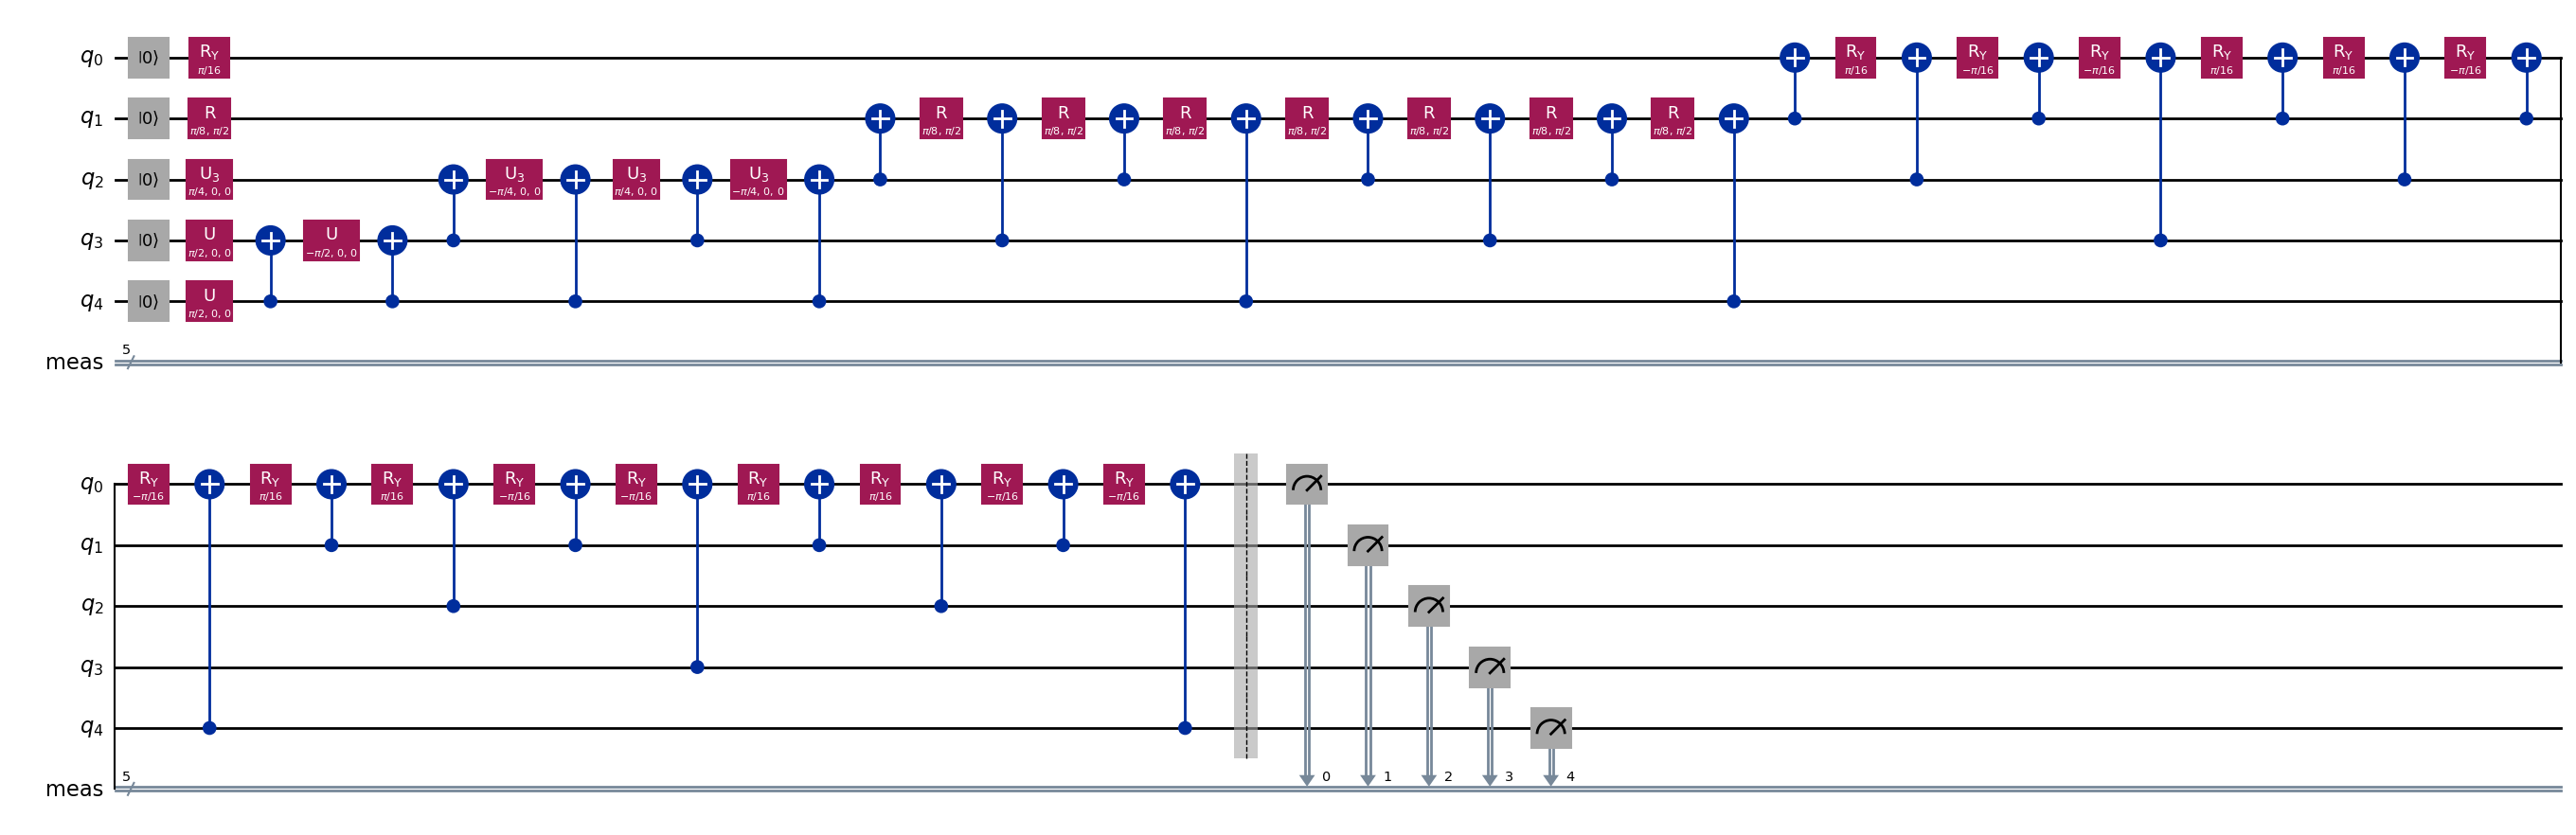

In [9]:
# Draw the decomposition of the amplitude embedding circuit
qc.decompose(reps=8).draw(output="mpl", fold=40)

<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 

Build the ansatz using the ```RealAmplitudes``` circuit from the Qiskit circuit library. The ansatz should look as follows:

</div>

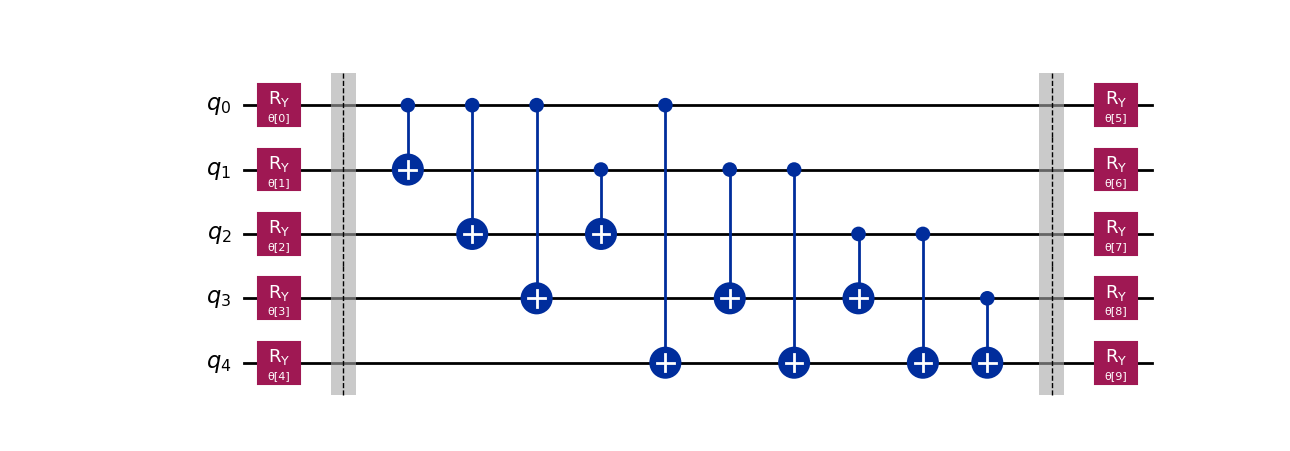

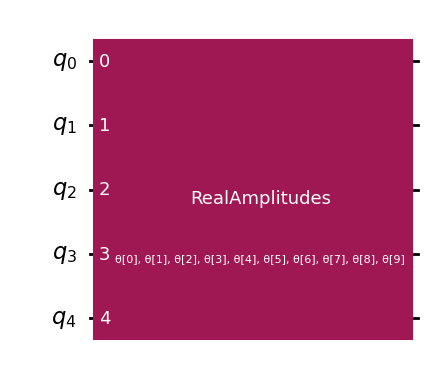

In [10]:
num_qubits = 5 # Add your code here
reps = 1 # Add your code here
entanglement = 'full' # Add your code here
ansatz = RealAmplitudes(num_qubits, entanglement='full', reps=1) # Add your code here
# Add code here to draw the ansatz circuit
ansatz.draw(output="mpl")

In [11]:
# Submit your answer using following code
grade_lab4_ex2(num_qubits, reps, entanglement)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Steps 2 & 3: Optimize the problem for quantum execution and execute it using Qiskit primitives

In [11]:
# Define the observable 
obs = SparsePauliOp("ZZZZZ")

In [12]:
# Define the estimator and pass manager
estimator = StatevectorEstimator()                              #To train we use StatevectorEstimator to get the exact simulation
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3, seed_transpiler=0) 

In [13]:
# Define the cost function
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )
    
    return cost

### Step 4: Classical post-processing stage

The last step of Qiskit Patterns includes any classical post-processing that we might run on the results. For the case of variational quantum algorithms, this stage includes the classical optimization of the ansatz parameters in order to minimize the cost function we have defined previously. This is the part in which we **TRAIN** the VQC.

To start the training, we need to define an initial set of parameters. Choosing this initial point is a very important step! A bad initial point can lead to severe complications in the training process. In particular, if the optimizer gets stuck in local minima we cannot converge to the optimal solution. 

Here, we will use five pre-saved configurations of initial parameters for the VQC, which can be found in `params_0_list.npy`.

<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warning:</b> Training can take around 2 minutes!
    
</div>

In [14]:
# Intialize the lists to store the results from different runs
cost_history_list = []
res_list = []

# Retrieve the initial parameters
params_0_list = np.load("params_0_list.npy")

for it, params_0 in enumerate(params_0_list):

    print('Iteration number: ', it)
    
    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func, 
        params_0, 
        args=(list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict), 
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations
    
    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])

Iteration number:  0
 message: Optimization terminated successfully.82]]
 success: True
  status: 1
     fun: 4.057929433107382
       x: [ 3.739e+00 -1.799e-01  2.141e-02  3.719e+00  4.955e+00
            1.571e+00  2.475e-06  6.028e+00  2.534e+00  3.102e+00]
    nfev: 195
   maxcv: 0.0
Iteration number:  1
 message: Optimization terminated successfully.41]]
 success: True
  status: 1
     fun: 5.000060186657541
       x: [ 4.356e-03 -1.542e-04  3.449e-01 -3.696e-01  1.871e+00
            6.839e-01  1.566e+00  1.227e+00  1.105e+00 -9.954e-02]
    nfev: 117
   maxcv: 0.0
Iteration number:  2
 message: Optimization terminated successfully.53]]
 success: True
  status: 1
     fun: 4.095589526823153
       x: [ 4.031e+00  3.166e+00  3.205e+00  3.386e+00  1.022e+00
            2.308e+00  3.131e+00  3.057e+00  3.192e+00  2.573e+00]
    nfev: 139
   maxcv: 0.0
Iteration number:  3
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 4.4277

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

    
<b> Exercise 3:</b> 

In this exercise, you need to check which set of initial parameters yield the best convergence. For this, you need to define two functions that will be used throughout the Lab:

1. A function ```test_VQC```, which applies the circuit with optimal parameters to each of the birds in the data set and outputs the converged value of the cost function.
2. A function ```compute performance``` which outputs the total performance (P) for each set of optimal parameters, which is defined as 

$P = 100 - 100\cdot\sum_{i\in \text{birds}} \frac{\vert (\langle \psi_i(\theta_{opt}) \vert \hat{O} \vert \psi_i(\theta_{opt})\rangle - L_i\vert}{2^5}$.
 
</div>  

In [15]:
def test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        list: List of test results
    """
    ### Write your code below here ###
    results_test=[]
    cost = 0
    
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        
        # append results
        results_test.append(result)

        # Compute cost function (cumulative)
        cost += np.abs(result - label)
        
    ### Don't change any code past this line ###                                 
    return results_test

In [16]:
def compute_performance(result_list, list_labels):
    
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        float: Performance of the classifier
    """
    ### Write your code below here ###

    performance_num = np.sum(np.abs(np.array(result_list) - np.array(list_labels)))

    performance = 100 - (100*performance_num/(2**5))
        
    ### Don't change any code past this line ###                                    
    return performance

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


Performance for trial 0: 87.31897052153943
Performance for trial 1: 84.3748119166952
Performance for trial 2: 87.20128272867765
Performance for trial 3: 86.1632841945264
Performance for trial 4: 99.99999469572624


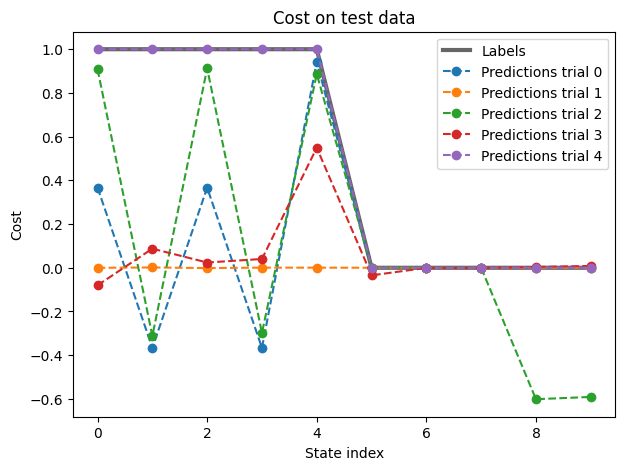

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

for index in range(len(res_list)):
    opt_params = res_list[index].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)
    print(f"Performance for trial {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions trial '+str(index))

ax.legend()

In [18]:
# Submit your answer using following code
best_result_index = 4   # Choose the index with the best result
grade_lab4_ex3(res_list[best_result_index]) # Expected result type: OptimizeResult

Grading your answer. Please wait...
Performance: 100.00% > 90%
Congratulations! 🎉 Your answer is correct.


## Part 2: Impact of noise on the performance of the VQC

Now that our VQC is trained, we want to test whether it is still able to distinguish the two sets of birds when we add noise in a controlled manner. In this part of the Lab, we focus on local testing, meaning that we are going to simulate quantum noise on our local machine. For this reason, we will create a custom fake backend. But first, let’s talk a bit about different types of quantum noise:

1. **Decoherence**: Qubits will lose their information of the quantum state over time, especially if they stay idle after they are initialized. For decoherence we normally don't use an error rate, but instead use T1 and T2 time, the amount of time it takes until a qubit loses its information.
2. **Measurement Errors**: Measuring qubits can cause errors, meaning that instead of a 0, a 1 is measured, and vice versa. This works similar to a classical channel.
3. **Gate Errors**: Gates are not perfect and have a small chance to introduce an error when applied. This is especially true for two-qubit gates, like the CX, the CZ, or the ECR gate, which normally have roughly a 10x higher error rate than single-qubit gates.
4. **Crosstalk Errors**: When applying a gate to a qubit, other qubits, especially neighboring ones, can also be influenced. This is even the case if these qubits lie idle. Fortunately, on the newest Heron devices, this is less of a problem, but it is still something to be aware of.

We can see the coherence times as well as the error rates of quantum devices directly on the [IBM Quantum systems page](https://quantum.ibm.com/services/resources) when inspecting a device. Here is a short overview:

Now that we have learned about noise, we want to make some noise, by using Qiskit to create a custom fake backend. For this, we will use the [GenericBackendV2 class](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.GenericBackendV2), which allows us to specify the noise levels and the connectivity of the backend we want to simulate. We assume the default all-to-all connectivity of `GenericBackendV2`.

In [19]:
fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

Using the Generic Backend as it is not that useful, since in the end we usually want to create a fake backend that behaves as similarly as possible to a specific backend on which we want to run our quantum circuit on. In this part of the Lab, we will show you how to change the properties of the generic fake backend we have just created in a controlled manner, and thus adapt it to our needs. For this we will now create a helper function, ```update_error_rate```:

In [20]:
def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

We will now use the function to change the error rate of all gates to $1e-8$, and we will also change the duration of the gates to the same number:

In [21]:
error_rates = {
  "default_duration": 1e-8,
  "rz_error": 1e-8,
  "x_error": 1e-8,
  "sx_error": 1e-8,
  "measure_error": 1e-8,
  "cx_error": 1e-8
}

update_error_rate(fake_backend, error_rates)

<a id="exercise4"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 4:</b> 

Let's **TEST** the VQC again on the custom fake backend for different error rates and check whether we recognize the results from exercise 3.

- Whenever working with fake backends or real backends, we need to make sure we are transpiling both the circuit and the observable. You can find an example of this in the _New primitives design_ section of the recent [Qiskit SDK v1.0 blog post](https://www.ibm.com/quantum/blog/qiskit-1-0-release-summary#new-primitives-design).
- Test the VQC for different error rates for the `RZ` and `CX` gates. In each case, you will need to use the ```update_error_rate``` function. 
- Use the optimal parameters from the best run of exercise 3.
- Compute the total performance `(P)` for each error rate using the function that you created previously and plot the final cost compared to the labels of each bird.
</div>

Performance for run 4: 84.1583251953125
Performance for run 4: 86.80877685546875
Performance for run 4: 97.3541259765625
Performance for run 4: 99.53765869140625


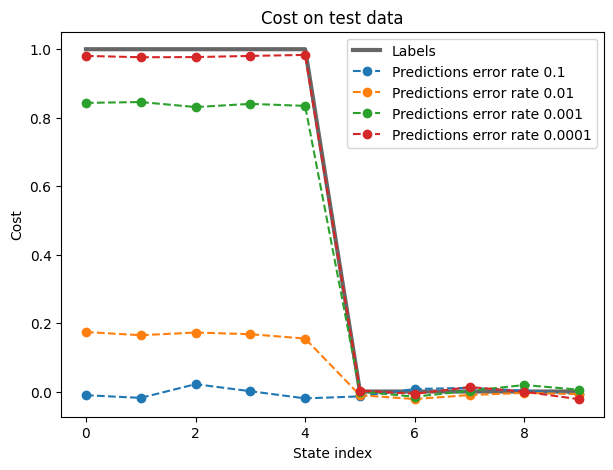

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

error_rate_list = [1e-1, 1e-2, 1e-3, 1e-4]

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

for error_rate_value in error_rate_list:

    error_rates['rz_error'] = error_rate_value
    error_rates['cx_error'] = error_rate_value

    update_error_rate(fake_backend, error_rates) # Add your code here
    
    estimator = Estimator(backend=fake_backend)   # Add your code here
    pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend, seed_transpiler=0) # Add your code here

    opt_params = res_list[best_result_index].x # Add your code here
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)

    print(f"Performance for run {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions error rate '+str(error_rate_value))
    
ax.legend()

In [142]:
# Submit your answer using following code
grade_lab4_ex4(fake_backend) # Expected answer type: BackendV2

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Part 3: Test the VQC on quantum hardware

In [23]:
# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

In [24]:
index_bird = 0 #you can check different birds by changing the index
qc = QuantumCircuit(num_qubits)
qc.initialize(list_coefficients[index_bird])
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
#transpiled_qc.draw(output="mpl", idle_wires=False, fold=40)

Depth of two-qubit gates:  39


<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 5:</b> 

Create a function to map the states more efficiently. For this we need to look closer at the data set and understand how it was built. Whenever we want to run our code on the hardware, we always need to use the structure of our data and our problem wisely!

- **IBM Quantum birds** correspond to the first 5 entries of the dictionary, with indices $0$, $1$, $2$, $3$, $4$. Their states are creating by:
    - We start by generating a GHZ state starting using the function ```generate_GHZ```.
    - Then, we change the index to its binary representation with 5 digits. For example, bird number $2$ corresponds to the binary number $00010$. This means we need to add a bit flip on the second last qubit.
    - This leads to a final GHZ state which will be $\vert 00010 \rangle + \vert 11101 \rangle$ for the bird number $2$ or $\vert 00011 \rangle + \vert 11100 \rangle$ for the bird number $3$.

- **non-IBM Quantum birds** correspond to the last 5 entries of the dictionary, with indices $5$, $6$, $7$, $8$, $9$. Here, the state is simply the product state corresponding to the binary representation of the index, as indicated in the second step above.

</div> 

In [25]:
def amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i in range(1, num_qubits):
            qc.cx(0, i)
            
    ### Write your code below here ###

    qc = QuantumCircuit(num_qubits)

    # Generate binary representation of the bird index

    if bird_index < 5:  # IBM Quantum birds
        generate_GHZ(qc)
        binary_index = format(bird_index, '05b')
        for q in range(num_qubits):
            if binary_index[q] == '1':
                qc.x(num_qubits-1-q) 

    else:  
        binary_index = format(bird_index, '05b')
        for q in range(num_qubits):
            if binary_index[q] == '1':
                qc.x(num_qubits-1-q)

    ### Don't change any code past this line ###
    return qc

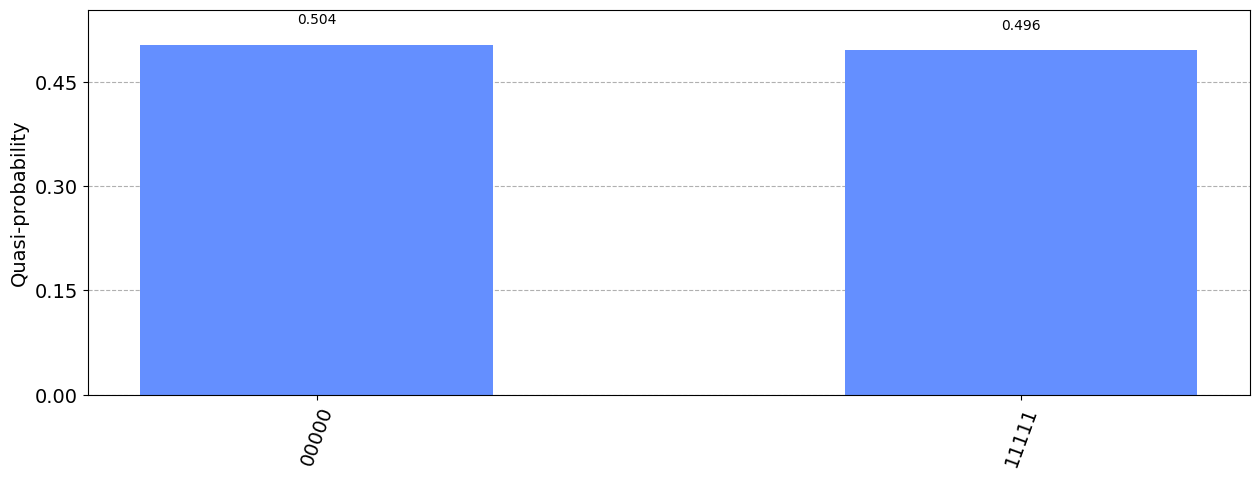

In [26]:
index_bird = 0 # You can check different birds by changing the index

# Build the amplitude embedding 
qc = amplitude_embedding(num_qubits, index_bird)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(backend=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(15, 5))

Now, let's check the depth of the new amplitude embedding circuit:

Depth of two-qubit gates:  7


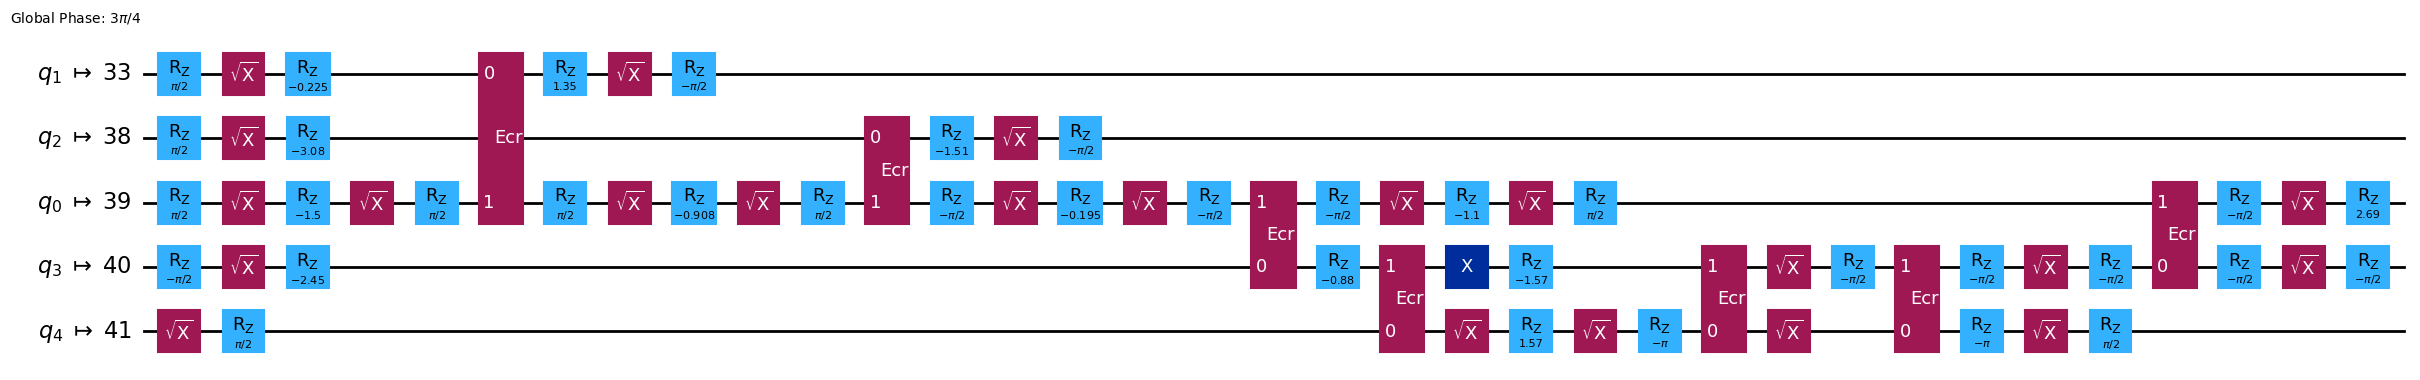

In [27]:
index_bird = 0 #You can check different birds by changing the index
qc = amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

In [228]:
# Submit your answer using following code
grade_lab4_ex5(amplitude_embedding) # Expected answer type Callable

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [28]:
old_ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='full', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(old_ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
#transpiled_ansatz.draw(output="mpl", idle_wires=False, fold=40)

Depth of two-qubit gates:  16


<a id="exercise6"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 6:</b> 

Create a new ```test_shallow_VQC``` function with the updated circuit. This function should implement the new amplitude embedding step and the new ansatz. Note that at this point we do not need the list of the coefficients anymore, since we are mapping each bird directly by its index.

</div> 

In [29]:
def test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        results_test (list): List of test results
    """
    ### Write your code below here ###

    results_test = []
    cost = 0

    for bird_index, label in enumerate(list_labels):

        new_map = amplitude_embedding(num_qubits, bird_index)
        classifier = new_map.compose(ansatz)
        t_classifier = pm.run(classifier)
        t_obs = obs.apply_layout(layout=t_classifier.layout)
        pub = (t_classifier, t_obs, opt_params)
        job=estimator.run([pub])
        result = job.result()[0].data.evs
        cost+=np.abs(result)
        results_test.append(abs(result))

        
    ### Don't change any code past this line ###                       
    return results_test

Performance: 84.34906005859375


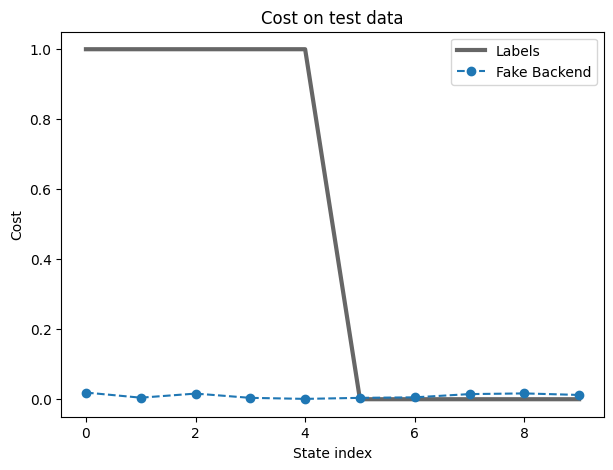

In [30]:
estimator = Estimator(backend=fake_backend)
estimator.options.default_shots = 5000
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

opt_params = np.load('opt_params_shallow_VQC.npy') # Load optimal parameters
results_test = test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm)

print(f"Performance: {compute_performance(results_test, list_labels)}")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')
ax.plot(results_test, 'o--', label='Fake Backend')
ax.legend()

In [31]:
# Submit your answer using following code
grade_lab4_ex6(results_test) # Expected answer type: list[float]

Grading your answer. Please wait...

Oops 😕! Performance: 49.92% < 70%
Please review your answer and try again.
